In [10]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter

# === Load .npy files ===
X_seq = np.load("X_seq.npy")  # shape: (N, 100, 1024)
y_seq = np.load("y_seq.npy")  # shape: (N,)

X_balanced = X_seq
y_balanced = y_seq

# === Split into train/test (stratified) ===
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# === Further split train into train/val (stratified) ===
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_np, y_train_np, test_size=0.1, stratify=y_train_np, random_state=42
)

# === Convert to PyTorch tensors ===
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.long)

# === Wrap in TensorDataset ===
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# === DataLoaders ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("✅ Balanced DataLoaders ready:")
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


✅ Balanced DataLoaders ready:
Train: 7726 | Val: 859 | Test: 2147


In [2]:
from sklearn.utils.class_weight import compute_class_weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = np.unique(y_balanced)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_balanced)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

In [3]:
# === Check class presence ===
def count_unique_classes(dataset, name):
    labels = torch.tensor([label.item() for _, label in dataset])
    unique_classes = torch.unique(labels)
    print(f"{name} has {len(unique_classes)} unique classes: {sorted(unique_classes.tolist())}")

count_unique_classes(train_dataset, "Train")
count_unique_classes(val_dataset, "Validation")
count_unique_classes(test_dataset, "Test")

from collections import Counter

def print_class_distribution(dataset, name):
    labels = [label.item() for _, label in dataset]
    class_counts = Counter(labels)
    print(f"\n{name} class distribution:")
    for cls in sorted(class_counts):
        print(f"Class {cls}: {class_counts[cls]} samples")

print_class_distribution(train_dataset, "Train")
print_class_distribution(val_dataset, "Validation")
print_class_distribution(test_dataset, "Test")



Train has 57 unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Validation has 57 unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Test has 57 unique classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]

Train class distribution:
Class 0: 720 samples
Class 1: 29 samples
Class 2: 29 samples
Class 3: 29 samples
Class 4: 29 samples
Class 5: 337 samples
Class 6: 29 samples
Class 7: 29 samples
Class 8: 720 samples
Class 9: 29 samples
Class 10: 29 samples
C

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YAMNet1DCNN_Improved(nn.Module):
    def __init__(self, num_classes=57):
        super().__init__()
        self.conv1 = nn.Conv1d(1024, 512, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(512, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.65)  # Slightly higher for better regularization
        self.fc = nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 100, 1024) → (B, 1024, 100)
        x = self.pool1(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool2(F.gelu(self.bn2(self.conv2(x))))
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.global_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)


In [17]:
class YAMNetMLP(nn.Module):
    def __init__(self, num_classes=57):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):  # x: (B, 100, 1024)
        x = self.mlp(x)              # (B, 100, 128)
        x = x.mean(dim=1)            # (B, 128) – average over time steps
        return self.classifier(x)    # (B, num_classes)


In [18]:
class YAMNetLSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1, num_classes=57, dropout=0.1, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1024,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        output_size = hidden_size * 2 if bidirectional else hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(output_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):  # x: (B, 100, 1024)
        out, _ = self.lstm(x)        # out: (B, 100, H*2)
        out = out.mean(dim=1)        # mean pool over 100 frames → (B, H*2)
        return self.classifier(out)  # → (B, num_classes)

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os

def train_and_evaluate(model, model_name, train_loader, val_loader, test_loader,
                       class_weights_tensor=None, epochs=100, patience=30, save_threshold=90, starting_lr=1e-3, saved_dir="models/"):


    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, min_lr=1e-6)

    best_val_acc = 0
    no_improve_epochs = 0
    saved_model_name = None

    # Metrics
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (preds.argmax(1) == yb).sum().item()

        train_acc = 100. * correct / len(train_loader.dataset)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(1) == yb).sum().item()
                val_total += yb.size(0)
        val_acc = 100. * val_correct / val_total
        val_accuracies.append(val_acc)

        scheduler.step(val_acc)

        print(f"[{model_name}] Epoch {epoch}: Loss={total_loss:.2f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

        # Save best
        if val_acc >= save_threshold:
            val_str = f"{val_acc:.2f}".replace('.', '_')
            # Inside your saving block:
            saved_model_name = os.path.join(saved_dir, f"{model_name}_{val_str}_Epoch{epoch}.pt")
            torch.save(model.state_dict(), saved_model_name)

            
            
            
            print(f"✅ Saved model: {saved_model_name} (Val Acc: {val_acc:.2f}%)")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("⛔ Early stopping triggered.")
                break

    # Evaluate
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            preds = model(xb)
            all_preds.append(preds)

    all_preds = torch.cat(all_preds).argmax(1).cpu().numpy()
    y_test_np = test_loader.dataset.tensors[1].cpu().numpy()
    test_acc = accuracy_score(y_test_np, all_preds)
    print(f"\n✅ Final Test Accuracy for {model_name}: {test_acc * 100:.2f}%")

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epoch")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(val_accuracies, label="Val Acc")
    plt.title(f"{model_name} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [20]:
import os
import torch
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

def find_best_model_name(
    model_type_prefix, 
    model_class, 
    test_loader, 
    metric='test_acc',
    model_dir='.'    # New parameter for model directory
):
    """
    Finds the best model filename by specified metric in a given directory.

    Args:
        model_type_prefix (str): e.g., 'CNN', 'MLP', etc.
        model_class (nn.Module): Model class to instantiate and load.
        test_loader (DataLoader): Test data.
        metric (str): 'test_acc' or 'avg_class_acc'.
        model_dir (str): Directory containing model files.

    Returns:
        str: Best model filename (with path relative to model_dir).
    """
    model_files = [
        f for f in os.listdir(model_dir)
        if f.startswith(model_type_prefix) and f.endswith('.pt')
    ]
    if not model_files:
        raise FileNotFoundError(f"No model files found for prefix: {model_type_prefix} in {model_dir}")

    results = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for file in model_files:
        file_path = os.path.join(model_dir, file)
        model = model_class().to(device)
        model.load_state_dict(torch.load(file_path, map_location=device))
        model.eval()

        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        test_acc = accuracy_score(all_labels, all_preds) * 100
        cm = confusion_matrix(all_labels, all_preds)
        per_class_acc = np.diag(cm) / np.maximum(cm.sum(axis=1), 1)
        avg_class_acc = np.mean(per_class_acc) * 100

        results.append((file, test_acc, avg_class_acc))

    if metric == 'test_acc':
        best_model = max(results, key=lambda x: x[1])
    elif metric == 'avg_class_acc':
        best_model = max(results, key=lambda x: x[2])
    else:
        raise ValueError("metric must be 'test_acc' or 'avg_class_acc'")

    # Return full path to best model
    return os.path.join(model_dir, best_model[0])


In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def evaluate_model(
    model_name,
    model_class,
    model_path,
    test_loader,
    show_confusion_matrix=True,
    show_classification_report=True,
    show_per_class_accuracy=True,
    show_avg_per_class=True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Overall Accuracy for {model_name}: {acc * 100:.2f}%")

    # === Classification Report ===
    if show_classification_report:
        print("\n📄 Classification Report:")
        print(classification_report(all_labels, all_preds, zero_division=0))

    # === Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    if show_confusion_matrix:
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix — {model_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    # === Per-Class Accuracy ===
    if show_per_class_accuracy:
        class_counts = cm.sum(axis=1)
        correct_counts = np.diag(cm)
        class_accuracy = correct_counts / np.maximum(class_counts, 1)

        plt.figure(figsize=(14, 6))
        plt.bar(range(len(class_accuracy)), class_accuracy)
        plt.xticks(ticks=range(len(class_accuracy)), labels=range(len(class_accuracy)), rotation=90)
        plt.ylim(0, 1.05)
        plt.ylabel("Accuracy")
        plt.title(f"Per-Class Accuracy — {model_name}")
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

        print("\n📊 Per-Class Accuracy:")
        for i, acc in enumerate(class_accuracy):
            print(f"Class {i:<2}: {acc * 100:.2f}%")

        if show_avg_per_class:
            avg_class_acc = np.mean(class_accuracy)
            print(f"\n📈 Average Per-Class Accuracy: {avg_class_acc * 100:.2f}%")


[CNN] Epoch 0: Loss=906.41, Train Acc=15.62%, Val Acc=45.75%
[CNN] Epoch 1: Loss=642.75, Train Acc=39.23%, Val Acc=55.41%
[CNN] Epoch 2: Loss=504.20, Train Acc=51.24%, Val Acc=64.03%
[CNN] Epoch 3: Loss=415.25, Train Acc=58.50%, Val Acc=70.31%
[CNN] Epoch 4: Loss=367.66, Train Acc=64.59%, Val Acc=72.76%
[CNN] Epoch 5: Loss=343.17, Train Acc=67.40%, Val Acc=75.79%
[CNN] Epoch 6: Loss=289.08, Train Acc=70.55%, Val Acc=76.37%
[CNN] Epoch 7: Loss=266.30, Train Acc=72.52%, Val Acc=78.00%
[CNN] Epoch 8: Loss=245.21, Train Acc=73.75%, Val Acc=78.00%
[CNN] Epoch 9: Loss=215.22, Train Acc=76.12%, Val Acc=79.28%
[CNN] Epoch 10: Loss=202.39, Train Acc=77.00%, Val Acc=81.14%
[CNN] Epoch 11: Loss=183.55, Train Acc=78.84%, Val Acc=81.96%
[CNN] Epoch 12: Loss=173.01, Train Acc=79.65%, Val Acc=81.37%
[CNN] Epoch 13: Loss=176.58, Train Acc=80.26%, Val Acc=82.07%
[CNN] Epoch 14: Loss=150.64, Train Acc=81.87%, Val Acc=82.31%
[CNN] Epoch 15: Loss=147.27, Train Acc=83.35%, Val Acc=82.42%
[CNN] Epoch 16: Lo

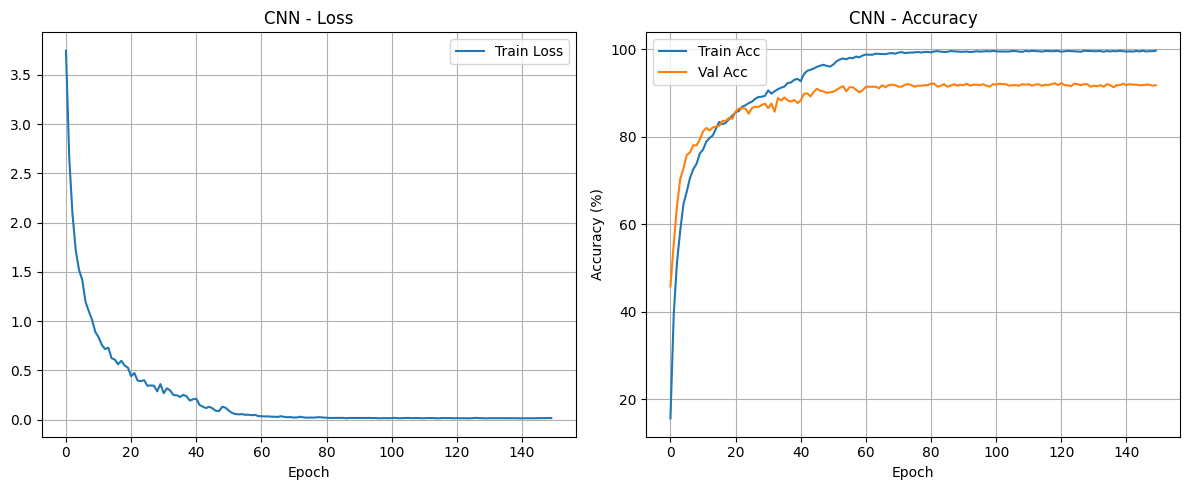

In [27]:
train_and_evaluate(YAMNet1DCNN_Improved(), "CNN", train_loader, val_loader, test_loader, class_weights_tensor,epochs = 150, patience=80, save_threshold=91.5)

Best CNN model: models/CNN_Models/TrainingLoop1\CNN_91_97_Epoch79.pt

✅ Overall Accuracy for CNN: 93.25%

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       200
           1       0.86      0.75      0.80         8
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         8
           4       0.89      1.00      0.94         8
           5       0.93      0.93      0.93        94
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       0.92      0.93      0.92       200
           9       1.00      0.88      0.93         8
          10       1.00      1.00      1.00         8
          11       1.00      0.88      0.93         8
          12       1.00      0.88      0.93         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
    

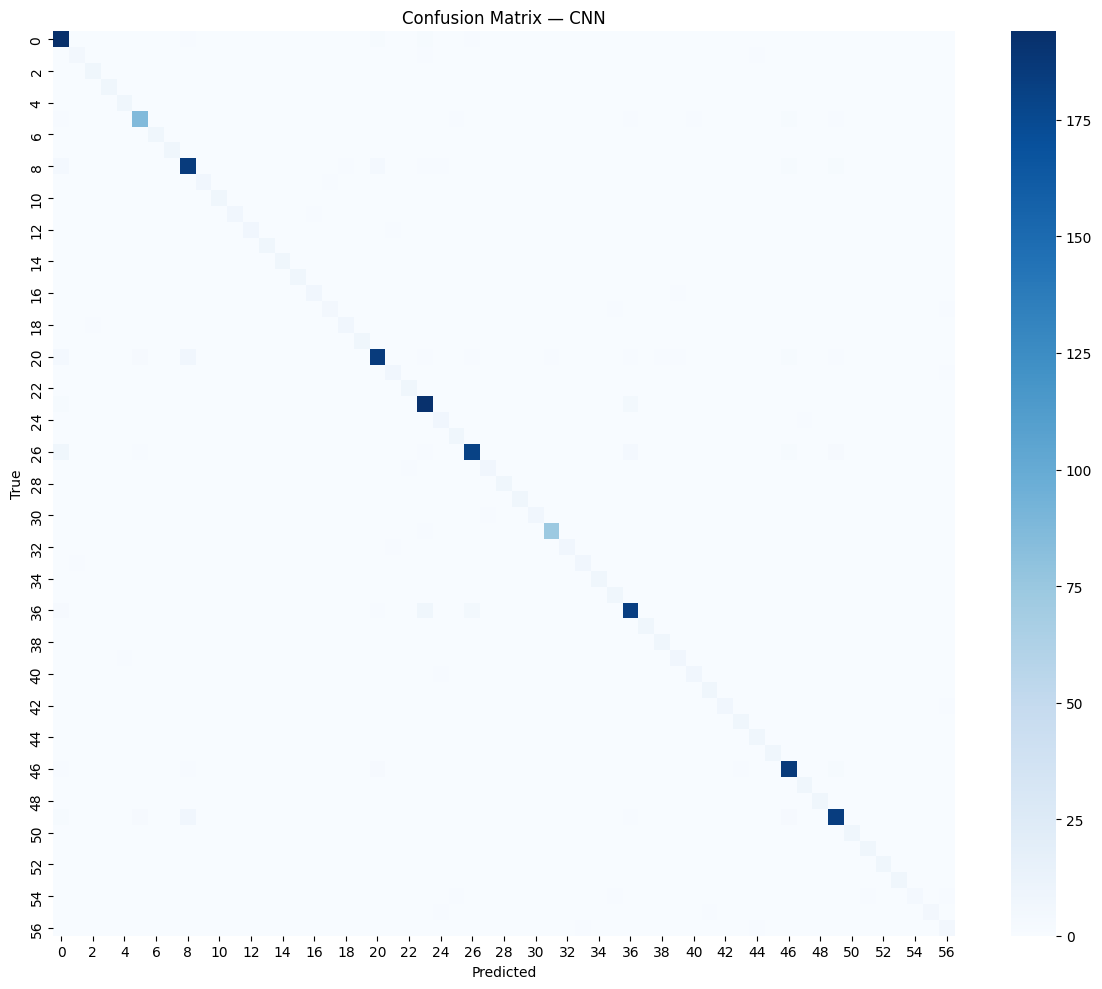

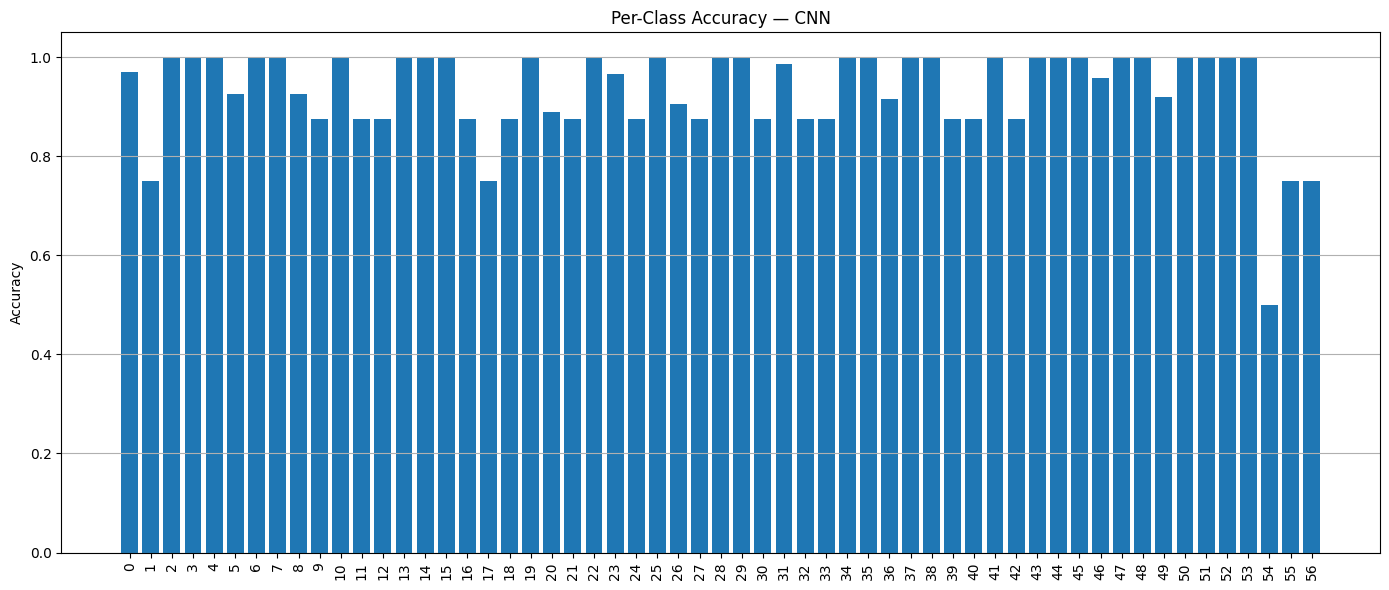


📊 Per-Class Accuracy:
Class 0 : 97.00%
Class 1 : 75.00%
Class 2 : 100.00%
Class 3 : 100.00%
Class 4 : 100.00%
Class 5 : 92.55%
Class 6 : 100.00%
Class 7 : 100.00%
Class 8 : 92.50%
Class 9 : 87.50%
Class 10: 100.00%
Class 11: 87.50%
Class 12: 87.50%
Class 13: 100.00%
Class 14: 100.00%
Class 15: 100.00%
Class 16: 87.50%
Class 17: 75.00%
Class 18: 87.50%
Class 19: 100.00%
Class 20: 88.94%
Class 21: 87.50%
Class 22: 100.00%
Class 23: 96.50%
Class 24: 87.50%
Class 25: 100.00%
Class 26: 90.50%
Class 27: 87.50%
Class 28: 100.00%
Class 29: 100.00%
Class 30: 87.50%
Class 31: 98.67%
Class 32: 87.50%
Class 33: 87.50%
Class 34: 100.00%
Class 35: 100.00%
Class 36: 91.50%
Class 37: 100.00%
Class 38: 100.00%
Class 39: 87.50%
Class 40: 87.50%
Class 41: 100.00%
Class 42: 87.50%
Class 43: 100.00%
Class 44: 100.00%
Class 45: 100.00%
Class 46: 95.88%
Class 47: 100.00%
Class 48: 100.00%
Class 49: 92.00%
Class 50: 100.00%
Class 51: 100.00%
Class 52: 100.00%
Class 53: 100.00%
Class 54: 50.00%
Class 55: 75.0

In [23]:
best_model_cnn = find_best_model_name(
    model_type_prefix="CNN",
    model_class=YAMNet1DCNN_Improved,
    test_loader=test_loader,
    metric='test_acc',
    model_dir='models/CNN_Models/TrainingLoop1'  # Specify the directory where models are saved
)
print(f"Best CNN model: {best_model_cnn}")

evaluate_model(
    model_name="CNN",
    model_class=YAMNet1DCNN_Improved,
    model_path=best_model_cnn,
    test_loader=test_loader,
    show_confusion_matrix=True,
    show_classification_report=True,
    show_per_class_accuracy=True,
    show_avg_per_class=True
)

[MLP] Epoch 0: Loss=766.57, Train Acc=20.54%, Val Acc=55.53%
[MLP] Epoch 1: Loss=349.21, Train Acc=53.62%, Val Acc=59.72%
[MLP] Epoch 2: Loss=248.88, Train Acc=62.57%, Val Acc=60.77%
[MLP] Epoch 3: Loss=195.34, Train Acc=67.27%, Val Acc=64.26%
[MLP] Epoch 4: Loss=167.92, Train Acc=69.16%, Val Acc=68.57%
[MLP] Epoch 5: Loss=149.86, Train Acc=71.45%, Val Acc=70.08%
[MLP] Epoch 6: Loss=136.20, Train Acc=73.30%, Val Acc=72.41%
[MLP] Epoch 7: Loss=119.75, Train Acc=74.50%, Val Acc=72.18%
[MLP] Epoch 8: Loss=113.27, Train Acc=75.81%, Val Acc=73.81%
[MLP] Epoch 9: Loss=109.54, Train Acc=77.05%, Val Acc=76.02%
[MLP] Epoch 10: Loss=91.58, Train Acc=78.18%, Val Acc=74.62%
[MLP] Epoch 11: Loss=87.88, Train Acc=79.33%, Val Acc=76.83%
[MLP] Epoch 12: Loss=77.62, Train Acc=79.74%, Val Acc=73.92%
[MLP] Epoch 13: Loss=79.45, Train Acc=80.21%, Val Acc=76.25%
[MLP] Epoch 14: Loss=72.85, Train Acc=81.74%, Val Acc=79.86%
[MLP] Epoch 15: Loss=67.88, Train Acc=81.72%, Val Acc=78.81%
[MLP] Epoch 16: Loss=67.

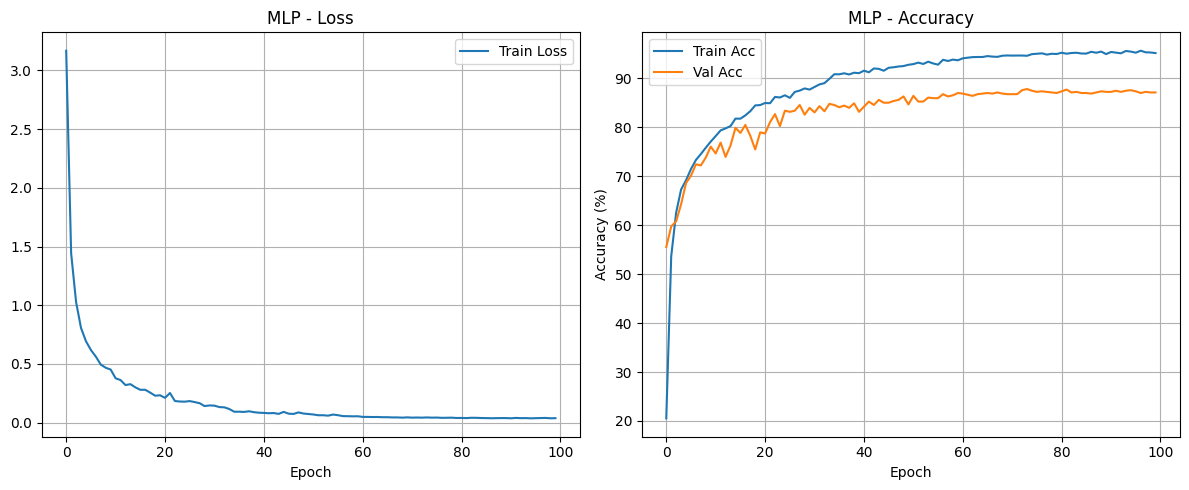

In [10]:
train_and_evaluate(YAMNetMLP(), "MLP", train_loader, val_loader, test_loader, class_weights_tensor, epochs=100, patience=100, save_threshold=87, saved_dir="models/MLP_Models/TrainingLoop2")

Best MLP model: models/MLP_Models/TrainingLoop2\MLP_87_08_Epoch67.pt

✅ Overall Accuracy for MLP: 89.15%

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       200
           1       0.60      0.38      0.46         8
           2       1.00      0.75      0.86         8
           3       1.00      1.00      1.00         8
           4       0.62      1.00      0.76         8
           5       0.86      0.95      0.90        94
           6       0.88      0.88      0.88         8
           7       0.80      1.00      0.89         8
           8       0.89      0.86      0.88       200
           9       0.67      0.75      0.71         8
          10       1.00      1.00      1.00         8
          11       1.00      0.88      0.93         8
          12       1.00      0.88      0.93         8
          13       0.89      1.00      0.94         8
          14       1.00      0.88      0.93         8
    

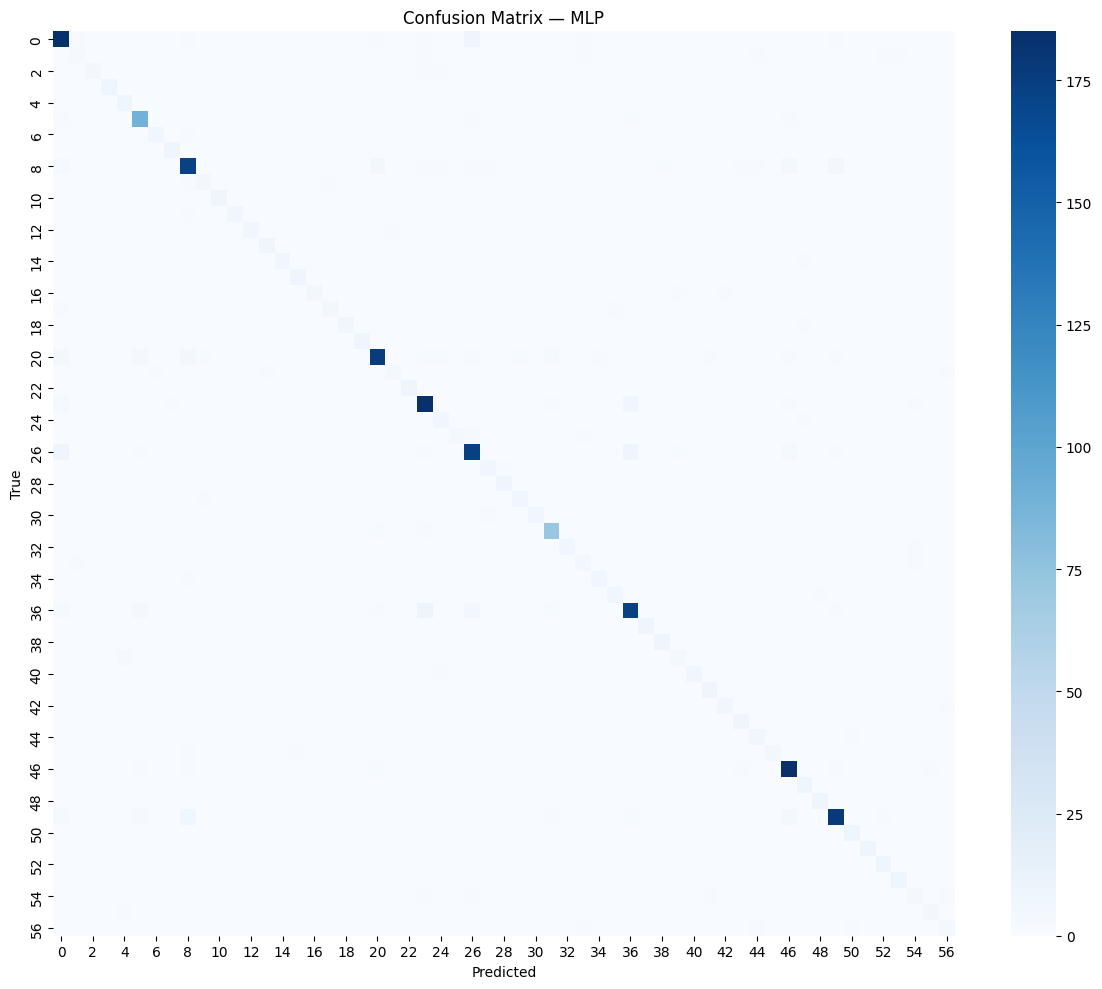

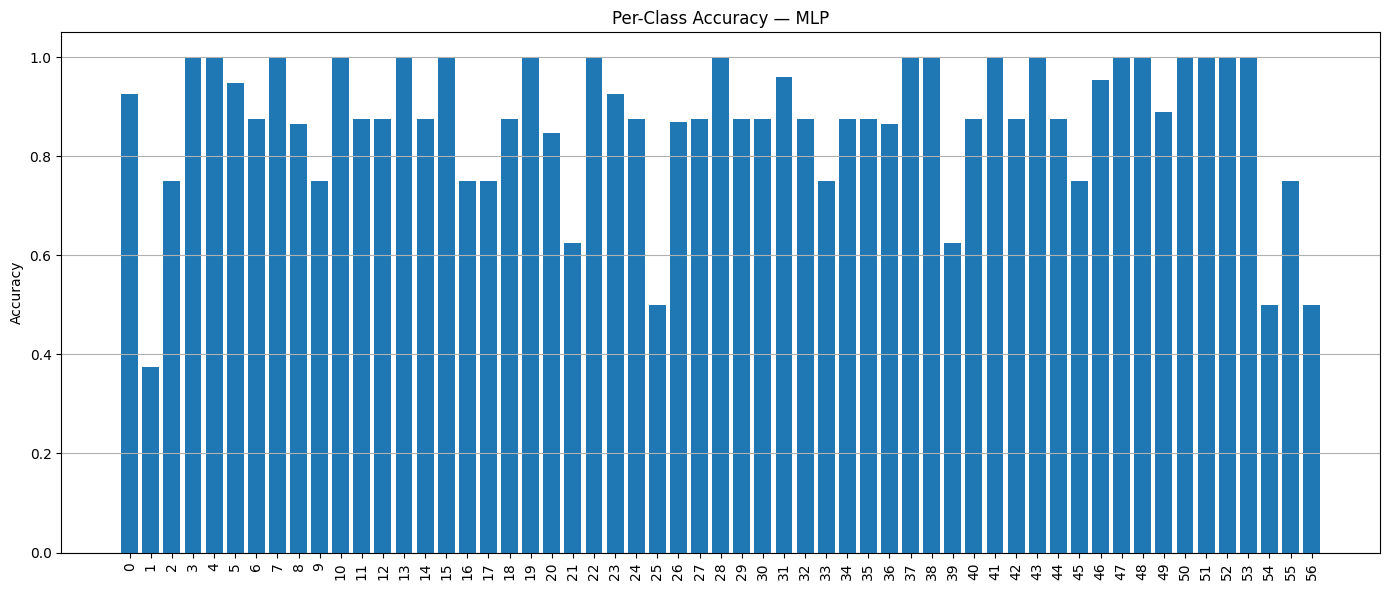


📊 Per-Class Accuracy:
Class 0 : 92.50%
Class 1 : 37.50%
Class 2 : 75.00%
Class 3 : 100.00%
Class 4 : 100.00%
Class 5 : 94.68%
Class 6 : 87.50%
Class 7 : 100.00%
Class 8 : 86.50%
Class 9 : 75.00%
Class 10: 100.00%
Class 11: 87.50%
Class 12: 87.50%
Class 13: 100.00%
Class 14: 87.50%
Class 15: 100.00%
Class 16: 75.00%
Class 17: 75.00%
Class 18: 87.50%
Class 19: 100.00%
Class 20: 84.62%
Class 21: 62.50%
Class 22: 100.00%
Class 23: 92.50%
Class 24: 87.50%
Class 25: 50.00%
Class 26: 87.00%
Class 27: 87.50%
Class 28: 100.00%
Class 29: 87.50%
Class 30: 87.50%
Class 31: 96.00%
Class 32: 87.50%
Class 33: 75.00%
Class 34: 87.50%
Class 35: 87.50%
Class 36: 86.50%
Class 37: 100.00%
Class 38: 100.00%
Class 39: 62.50%
Class 40: 87.50%
Class 41: 100.00%
Class 42: 87.50%
Class 43: 100.00%
Class 44: 87.50%
Class 45: 75.00%
Class 46: 95.36%
Class 47: 100.00%
Class 48: 100.00%
Class 49: 89.00%
Class 50: 100.00%
Class 51: 100.00%
Class 52: 100.00%
Class 53: 100.00%
Class 54: 50.00%
Class 55: 75.00%
Class 

In [11]:
best_model_mlp = find_best_model_name(
    model_type_prefix="MLP",
    model_class=YAMNetMLP,
    test_loader=test_loader,
    metric='avg_class_acc',
    model_dir="models/MLP_Models/TrainingLoop2"  # Specify the directory where models are saved
)
print(f"Best MLP model: {best_model_mlp}")

evaluate_model(
    model_name="MLP",
    model_class=YAMNetMLP,
    model_path=best_model_mlp,
    test_loader=test_loader,
    show_confusion_matrix=True,
    show_classification_report=True,
    show_per_class_accuracy=True,
    show_avg_per_class=True
)

[LSTM] Epoch 0: Loss=844.23, Train Acc=19.54%, Val Acc=37.37%
[LSTM] Epoch 1: Loss=517.56, Train Acc=41.21%, Val Acc=55.88%
[LSTM] Epoch 2: Loss=349.76, Train Acc=52.54%, Val Acc=56.46%
[LSTM] Epoch 3: Loss=249.39, Train Acc=60.15%, Val Acc=59.60%
[LSTM] Epoch 4: Loss=190.20, Train Acc=67.12%, Val Acc=68.45%
[LSTM] Epoch 5: Loss=152.56, Train Acc=70.26%, Val Acc=69.27%
[LSTM] Epoch 6: Loss=120.51, Train Acc=73.76%, Val Acc=75.55%
[LSTM] Epoch 7: Loss=106.60, Train Acc=76.17%, Val Acc=73.81%
[LSTM] Epoch 8: Loss=89.18, Train Acc=79.24%, Val Acc=73.34%
[LSTM] Epoch 9: Loss=79.41, Train Acc=79.38%, Val Acc=72.53%
[LSTM] Epoch 10: Loss=63.60, Train Acc=82.38%, Val Acc=80.33%
[LSTM] Epoch 11: Loss=58.94, Train Acc=82.59%, Val Acc=80.79%
[LSTM] Epoch 12: Loss=45.17, Train Acc=85.46%, Val Acc=81.14%
[LSTM] Epoch 13: Loss=51.65, Train Acc=83.94%, Val Acc=82.54%
[LSTM] Epoch 14: Loss=38.02, Train Acc=87.15%, Val Acc=82.31%
[LSTM] Epoch 15: Loss=32.48, Train Acc=87.70%, Val Acc=85.68%
[LSTM] Epo

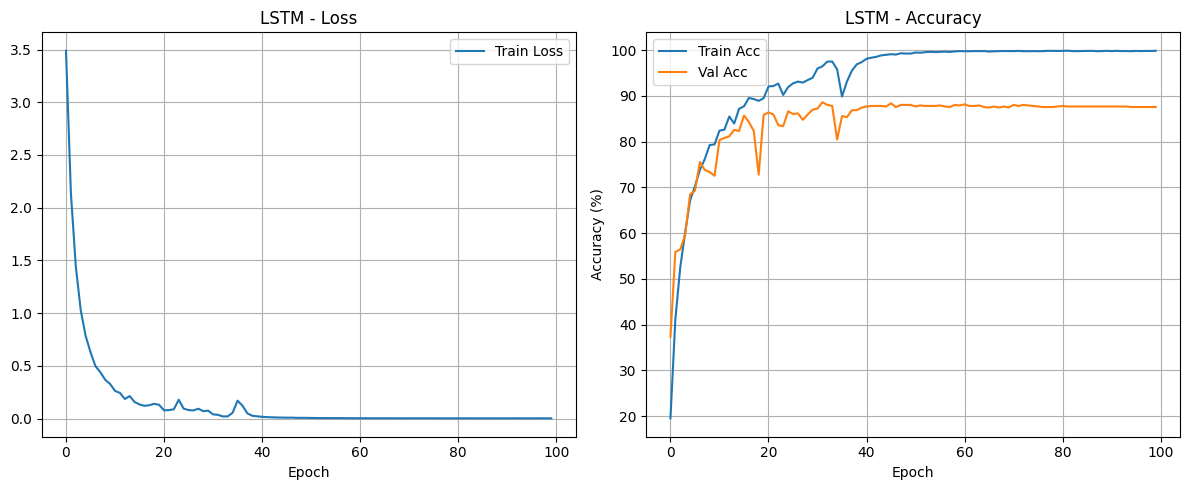

In [12]:
train_and_evaluate(YAMNetLSTM(), "LSTM", train_loader, val_loader, test_loader, class_weights_tensor, epochs=100, patience=50, save_threshold=87, starting_lr=1e-3, saved_dir="models/LSTM_Models/TrainingLoop2")

Best MLP model: models/LSTM_Models/TrainingLoop2\LSTM_87_43_Epoch39.pt

✅ Overall Accuracy for LSTM: 89.47%

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       200
           1       0.62      0.62      0.62         8
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00         8
           4       0.88      0.88      0.88         8
           5       0.89      0.90      0.90        94
           6       0.57      1.00      0.73         8
           7       0.80      1.00      0.89         8
           8       0.91      0.86      0.88       200
           9       0.67      0.75      0.71         8
          10       1.00      1.00      1.00         8
          11       1.00      0.88      0.93         8
          12       1.00      1.00      1.00         8
          13       0.88      0.88      0.88         8
          14       0.73      1.00      0.84         8
 

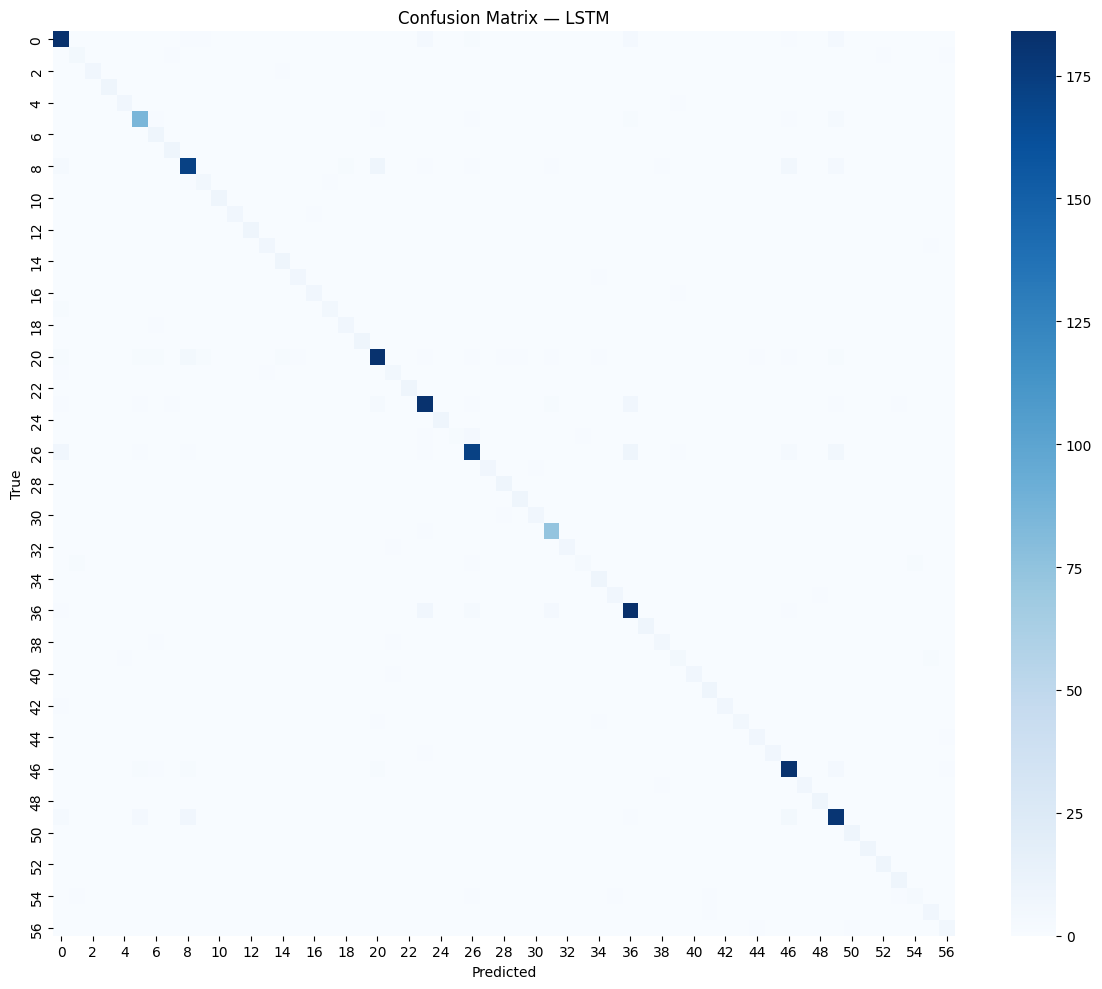

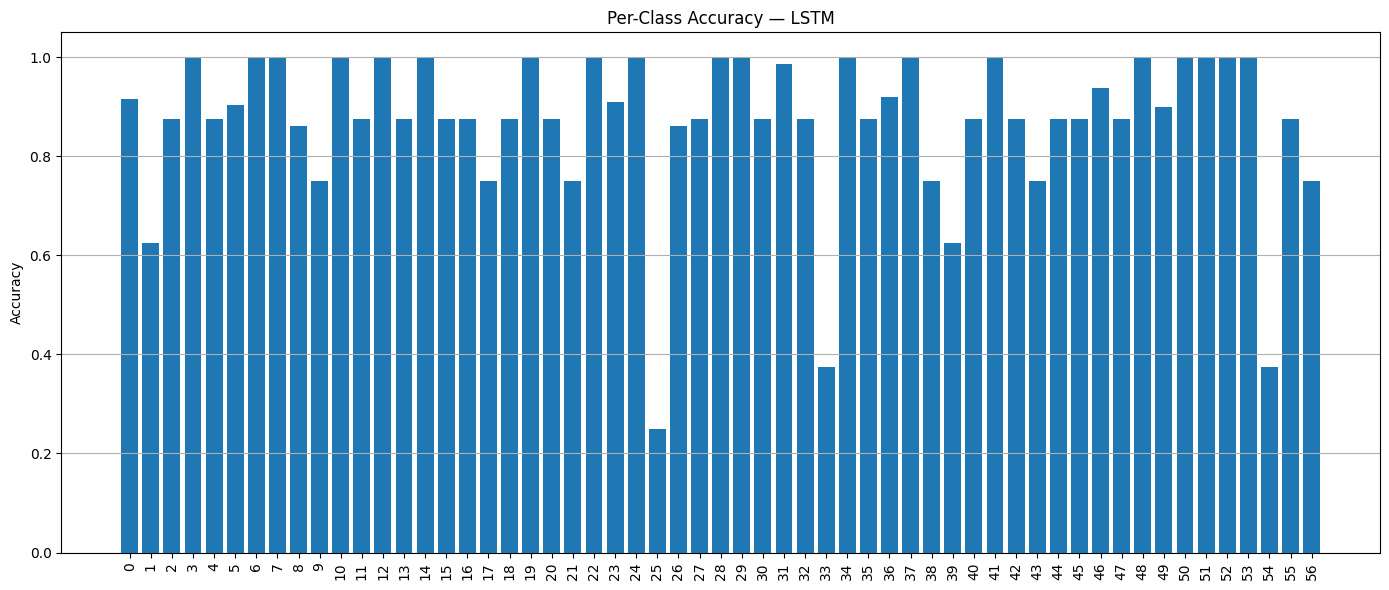


📊 Per-Class Accuracy:
Class 0 : 91.50%
Class 1 : 62.50%
Class 2 : 87.50%
Class 3 : 100.00%
Class 4 : 87.50%
Class 5 : 90.43%
Class 6 : 100.00%
Class 7 : 100.00%
Class 8 : 86.00%
Class 9 : 75.00%
Class 10: 100.00%
Class 11: 87.50%
Class 12: 100.00%
Class 13: 87.50%
Class 14: 100.00%
Class 15: 87.50%
Class 16: 87.50%
Class 17: 75.00%
Class 18: 87.50%
Class 19: 100.00%
Class 20: 87.50%
Class 21: 75.00%
Class 22: 100.00%
Class 23: 91.00%
Class 24: 100.00%
Class 25: 25.00%
Class 26: 86.00%
Class 27: 87.50%
Class 28: 100.00%
Class 29: 100.00%
Class 30: 87.50%
Class 31: 98.67%
Class 32: 87.50%
Class 33: 37.50%
Class 34: 100.00%
Class 35: 87.50%
Class 36: 92.00%
Class 37: 100.00%
Class 38: 75.00%
Class 39: 62.50%
Class 40: 87.50%
Class 41: 100.00%
Class 42: 87.50%
Class 43: 75.00%
Class 44: 87.50%
Class 45: 87.50%
Class 46: 93.81%
Class 47: 87.50%
Class 48: 100.00%
Class 49: 90.00%
Class 50: 100.00%
Class 51: 100.00%
Class 52: 100.00%
Class 53: 100.00%
Class 54: 37.50%
Class 55: 87.50%
Class 

In [46]:
best_model_lstm = find_best_model_name(
    model_type_prefix="LSTM",
    model_class=YAMNetLSTM,
    test_loader=test_loader,
    metric='avg_class_acc',
    model_dir="models/LSTM_Models/TrainingLoop2"  # Specify the directory where models are saved
)
print(f"Best MLP model: {best_model_lstm}")

evaluate_model(
    model_name="LSTM",
    model_class=YAMNetLSTM,
    model_path=best_model_lstm,
    test_loader=test_loader,
    show_confusion_matrix=True,
    show_classification_report=True,
    show_per_class_accuracy=True,
    show_avg_per_class=True
)

In [2]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

classes = np.unique(y_train_np)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
class_weight_dict = dict(zip(classes, class_weights))  # Map class → weight

# Step 2: Build per-sample weights from y_train_np
sample_weights = np.array([class_weight_dict[label] for label in y_train_np])
# Flatten (N, 100, 1024) → (N, 100*1024)
X_train_flat = X_train_np.reshape(X_train_np.shape[0], -1)
X_val_flat = X_val_np.reshape(X_val_np.shape[0], -1)
X_test_flat = X_test_np.reshape(X_test_np.shape[0], -1)

# === Reduce dimensionality ===
pca = PCA(n_components=1024, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)



In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

# === Train Logistic Regression
logreg = LogisticRegression(max_iter=1000, class_weight=class_weight_dict)
logreg.fit(X_train_pca, y_train_np)

# === Predict on test set
y_pred = logreg.predict(X_test_pca)

# === Evaluation
acc = accuracy_score(y_test_np, y_pred)
cm = confusion_matrix(y_test_np, y_pred, labels=range(57))
per_class_correct = np.diag(cm)
per_class_total = cm.sum(axis=1)
per_class_acc = 100 * per_class_correct / np.maximum(per_class_total, 1)

print(f"\n✅ Logistic Regression — Accuracy: {acc:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test_np, y_pred, zero_division=0))

logreg_accs = list(np.round(per_class_acc, 2))  # save this for hybrid model




✅ Logistic Regression — Accuracy: 0.88%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       200
           1       0.67      0.75      0.71         8
           2       0.86      0.75      0.80         8
           3       1.00      1.00      1.00         8
           4       1.00      0.75      0.86         8
           5       0.90      0.93      0.91        94
           6       0.89      1.00      0.94         8
           7       0.89      1.00      0.94         8
           8       0.85      0.87      0.86       200
           9       1.00      0.88      0.93         8
          10       1.00      1.00      1.00         8
          11       1.00      0.88      0.93         8
          12       1.00      0.88      0.93         8
          13       0.78      0.88      0.82         8
          14       1.00      1.00      1.00         8
          15       0.89      1.00      0.94         8
          16  

In [4]:
from sklearn.pipeline import Pipeline
import joblib

def save_pca_logreg(X_train_flat, y_train_np, class_weight_dict, save_path="logreg_pca_pipeline.pkl"):
    from sklearn.decomposition import PCA
    from sklearn.linear_model import LogisticRegression

    # Build the pipeline
    pipeline = Pipeline([
        ("pca", PCA(n_components=1024, random_state=42)),
        ("logreg", LogisticRegression(max_iter=1000, class_weight=class_weight_dict))
    ])
    pipeline.fit(X_train_flat, y_train_np)
    joblib.dump(pipeline, save_path)
    print(f"✅ Saved PCA + LogisticRegression pipeline to: {save_path}")
    return pipeline


In [5]:
pipeline = save_pca_logreg(X_train_flat, y_train_np, class_weight_dict)

✅ Saved PCA + LogisticRegression pipeline to: logreg_pca_pipeline.pkl


In [47]:
import joblib
import torch


# Load the pipeline
logreg_pipeline = joblib.load("logreg_pca_pipeline.pkl")

# 1. Instantiate model
cnn_model = YAMNet1DCNN_Improved(num_classes=57)

# 2. Load weights
cnn_model.load_state_dict(torch.load(best_model_cnn, map_location="cpu"))  # or your path

# 3. Move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model = cnn_model.to(device)

# 1. Instantiate model
lstm_model = YAMNetLSTM(num_classes=57)

# 2. Load weights
lstm_model.load_state_dict(torch.load(best_model_lstm, map_location="cpu"))  # or your path

# 3. Move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
lstm_model = cnn_model.to(device)



In [37]:
def predict_hybrid(x_cnn_input, x_raw_flat, cnn_model, logreg_pipeline, use_logreg_for_class=None, device="cpu"):
    """
    x_cnn_input: torch.Tensor (N, 100, 1024) or np.ndarray
    x_raw_flat: np.ndarray (N, 100*1024)
    """
    # Convert to tensor if needed
    if isinstance(x_cnn_input, np.ndarray):
        x_cnn_tensor = torch.from_numpy(x_cnn_input).float().to(device)
    elif torch.is_tensor(x_cnn_input):
        x_cnn_tensor = x_cnn_input.float().to(device)
    else:
        raise TypeError("x_cnn_input must be a torch.Tensor or np.ndarray")

    cnn_model.eval()
    with torch.no_grad():
        logits = cnn_model(x_cnn_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    # Logistic regression pipeline
    logreg_probs = logreg_pipeline.predict_proba(x_raw_flat)  # (N, num_classes)

    # Replace class probabilities
    if use_logreg_for_class is not None:
        if isinstance(use_logreg_for_class, int):
            use_logreg_for_class = [use_logreg_for_class]
        for class_idx in use_logreg_for_class:
            probs[:, class_idx] = logreg_probs[:, class_idx]
        probs /= probs.sum(axis=1, keepdims=True)

    preds = np.argmax(probs, axis=1)
    return preds, probs


In [39]:
X_test_np = X_test.numpy()  # for scikit-learn
X_test_flat = X_test_np.reshape(X_test_np.shape[0], -1)


In [49]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import json

def predict_hybrid(
    x_input,                    # torch.Tensor (N, 100, 1024) or np.ndarray
    x_raw_flat,                 # np.ndarray (N, 100*1024) for logreg (can be None if not used)
    cnn_model=None,             # torch model, optional
    logreg_pipeline=None,       # sklearn pipeline, optional
    lstm_model=None,            # torch model, optional
    use_logreg_for_class=None,  # list of int
    use_lstm_for_class=None,    # list of int
    device="cpu"
):
    # Always convert to tensor for PyTorch models
    if isinstance(x_input, np.ndarray):
        x_tensor = torch.from_numpy(x_input).float().to(device)
    elif torch.is_tensor(x_input):
        x_tensor = x_input.float().to(device)
    else:
        raise TypeError("x_input must be a torch.Tensor or np.ndarray")
    
    # Get probabilities from CNN (if given)
    if cnn_model is not None:
        cnn_model.eval()
        with torch.no_grad():
            logits_cnn = cnn_model(x_tensor)
            probs = torch.softmax(logits_cnn, dim=1).cpu().numpy()
    else:
        raise ValueError("cnn_model must be provided as the default base model.")

    # Get probabilities from LSTM (if given and needed)
    if lstm_model is not None and use_lstm_for_class is not None:
        lstm_model.eval()
        with torch.no_grad():
            logits_lstm = lstm_model(x_tensor)
            lstm_probs = torch.softmax(logits_lstm, dim=1).cpu().numpy()
        if isinstance(use_lstm_for_class, int):
            use_lstm_for_class = [use_lstm_for_class]
        for class_idx in use_lstm_for_class:
            probs[:, class_idx] = lstm_probs[:, class_idx]

    # Get probabilities from LogReg (if given and needed)
    if logreg_pipeline is not None and use_logreg_for_class is not None:
        if x_raw_flat is None:
            raise ValueError("x_raw_flat must be provided when using logreg.")
        logreg_probs = logreg_pipeline.predict_proba(x_raw_flat)  # (N, num_classes)
        if isinstance(use_logreg_for_class, int):
            use_logreg_for_class = [use_logreg_for_class]
        for class_idx in use_logreg_for_class:
            probs[:, class_idx] = logreg_probs[:, class_idx]

    # Optional: renormalize to sum to 1 (recommended)
    probs /= probs.sum(axis=1, keepdims=True)
    preds = np.argmax(probs, axis=1)
    return preds, probs

In [60]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def evaluate_per_class_accuracy(y_true, y_pred, class_names=None, print_report=True):
    """
    y_true, y_pred: arrays (N,)
    class_names: list of class labels (optional)
    print_report: whether to print per-class accuracies and classification report
    Returns: dict of per-class accuracy, macro avg, weighted avg
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n_classes = len(np.unique(y_true)) if class_names is None else len(class_names)
    cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    per_class_correct = np.diag(cm)
    per_class_total = cm.sum(axis=1)
    per_class_acc = 100 * per_class_correct / np.maximum(per_class_total, 1)

    if print_report:
        print("📊 Per-Class Accuracy:")
        for i, acc in enumerate(per_class_acc):
            cls = i if class_names is None else class_names[i]
            print(f"Class {cls:>2}: {acc:.2f}%")
        print(f"\n📈 Average Per-Class Accuracy: {per_class_acc.mean():.2f}%")
        print("\n📄 Classification Report:")
        print(classification_report(y_true, y_pred, digits=4, target_names=class_names))

    return {
        "per_class_accuracy": per_class_acc,
        "macro_avg": np.mean(per_class_acc),
        "weighted_avg": np.average(per_class_acc, weights=per_class_total)
    }

from sklearn.metrics import confusion_matrix
import numpy as np

def average_per_class_accuracy(y_true, y_pred, num_classes=None, verbose=True):
    """
    Returns the average per-class accuracy (macro recall).
    If a class is missing from y_true, its accuracy will be counted as 0%.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if num_classes is None:
        num_classes = max(np.max(y_true), np.max(y_pred)) + 1
    # Always use explicit labels so all classes are included, even if missing in y_true/y_pred
    labels = np.arange(num_classes)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    per_class_correct = np.diag(cm)
    per_class_total = cm.sum(axis=1)
    # If a class does not appear at all in y_true, set its accuracy to np.nan so it does not skew the mean
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class_acc = 100 * per_class_correct / per_class_total
        per_class_acc = np.where(per_class_total > 0, per_class_acc, np.nan)
    # Average over classes that appear in y_true (ignore NaN)
    avg_per_class_acc = np.nanmean(per_class_acc)
    if verbose:
        print("📊 Per-Class Accuracy:")
        for i, acc in enumerate(per_class_acc):
            print(f"Class {i:2d}: {acc if not np.isnan(acc) else 'N/A'}%")
        print(f"\n📈 Average Per-Class Accuracy: {avg_per_class_acc:.2f}%")
    return avg_per_class_acc, per_class_acc


In [61]:
preds, probs = predict_hybrid(
    X_test,                   # input for both CNN and LSTM
    X_test_flat,              # flattened input for LogReg
    cnn_model=cnn_model,
    logreg_pipeline=logreg_pipeline,
    lstm_model=lstm_model,
    use_logreg_for_class=[54],
    use_lstm_for_class=[12],
    device=device
)

# If y_test is a torch tensor:
if torch.is_tensor(y_test):
    y_test_np = y_test.numpy()
else:
    y_test_np = y_test


# preds, probs = predict_hybrid(...)
y_test_np = y_test.numpy() if torch.is_tensor(y_test) else y_test

avg_acc, per_class_acc = average_per_class_accuracy(y_test_np, preds)



📊 Per-Class Accuracy:
Class  0: 97.0%
Class  1: 75.0%
Class  2: 100.0%
Class  3: 100.0%
Class  4: 100.0%
Class  5: 92.55319148936171%
Class  6: 100.0%
Class  7: 100.0%
Class  8: 92.5%
Class  9: 87.5%
Class 10: 100.0%
Class 11: 87.5%
Class 12: 87.5%
Class 13: 100.0%
Class 14: 100.0%
Class 15: 100.0%
Class 16: 87.5%
Class 17: 75.0%
Class 18: 87.5%
Class 19: 100.0%
Class 20: 88.9423076923077%
Class 21: 87.5%
Class 22: 100.0%
Class 23: 96.5%
Class 24: 87.5%
Class 25: 100.0%
Class 26: 90.5%
Class 27: 87.5%
Class 28: 100.0%
Class 29: 100.0%
Class 30: 87.5%
Class 31: 98.66666666666667%
Class 32: 87.5%
Class 33: 75.0%
Class 34: 100.0%
Class 35: 100.0%
Class 36: 91.5%
Class 37: 100.0%
Class 38: 100.0%
Class 39: 87.5%
Class 40: 87.5%
Class 41: 100.0%
Class 42: 87.5%
Class 43: 100.0%
Class 44: 100.0%
Class 45: 100.0%
Class 46: 95.87628865979381%
Class 47: 100.0%
Class 48: 100.0%
Class 49: 92.0%
Class 50: 100.0%
Class 51: 100.0%
Class 52: 100.0%
Class 53: 100.0%
Class 54: 62.5%
Class 55: 75.0%
Cla

In [90]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

# === Train
svm = SVC(kernel='rbf', C=1.0, class_weight=class_weight_dict, gamma='scale')
svm.fit(X_train_pca, y_train_np)

# === Predict
y_pred = svm.predict(X_test_pca)

# === Evaluate
acc = accuracy_score(y_test_np, y_pred)
cm = confusion_matrix(y_test_np, y_pred, labels=range(57))
per_class_correct = np.diag(cm)
per_class_total = cm.sum(axis=1)
per_class_acc = 100 * per_class_correct / np.maximum(per_class_total, 1)

print(f"\n✅ SVM — Accuracy: {acc:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test_np, y_pred, zero_division=0))

svm_accs = list(np.round(per_class_acc, 2))  # save this for hybrid model

save_model_and_acc_list("SVM", svm, svm_accs)



✅ SVM — Accuracy: 0.79%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.85      0.72       200
           1       0.62      0.62      0.62         8
           2       0.86      0.75      0.80         8
           3       0.86      0.75      0.80         8
           4       0.38      0.62      0.48         8
           5       0.59      0.84      0.70        94
           6       0.64      0.88      0.74         8
           7       1.00      0.88      0.93         8
           8       0.82      0.91      0.86       200
           9       0.70      0.88      0.78         8
          10       1.00      1.00      1.00         8
          11       1.00      0.75      0.86         8
          12       1.00      0.88      0.93         8
          13       1.00      0.88      0.93         8
          14       0.62      0.62      0.62         8
          15       0.73      1.00      0.84         8
          16       0.78      0

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

# === Train Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf.fit(X_train_pca, y_train_np)

# === Predict on test set
y_pred = rf.predict(X_test_pca)

# === Evaluation
acc = accuracy_score(y_test_np, y_pred)
cm = confusion_matrix(y_test_np, y_pred, labels=range(57))
per_class_correct = np.diag(cm)
per_class_total = cm.sum(axis=1)
per_class_acc = 100 * per_class_correct / np.maximum(per_class_total, 1)

print(f"\n✅ Random Forest — Accuracy: {acc * 100:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test_np, y_pred, zero_division=0))

rf_accs = list(np.round(per_class_acc, 2))  # save this for hybrid model

# === Save model and accuracy
save_model_and_acc_list("RandomForest", rf, rf_accs)



✅ Random Forest — Accuracy: 79.88%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78       200
           1       1.00      0.12      0.22         8
           2       1.00      0.62      0.77         8
           3       0.86      0.75      0.80         8
           4       0.00      0.00      0.00         8
           5       0.91      0.74      0.82        94
           6       1.00      0.25      0.40         8
           7       1.00      0.62      0.77         8
           8       0.78      0.89      0.83       200
           9       1.00      0.50      0.67         8
          10       1.00      0.88      0.93         8
          11       1.00      0.62      0.77         8
          12       1.00      0.75      0.86         8
          13       0.80      0.50      0.62         8
          14       1.00      0.25      0.40         8
          15       0.00      0.00      0.00         8
          16       

In [93]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np

print("\n🔧 Training XGBoost (with PCA)...")

# === Train XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    tree_method='hist',           # fast training
    eval_metric='mlogloss',       # classification loss
    use_label_encoder=False,
    verbosity=1,
    random_state=42
)
xgb.fit(X_train_pca, y_train_np)

# === Predict on test set
y_pred = xgb.predict(X_test_pca)

# === Evaluation
acc = accuracy_score(y_test_np, y_pred)
cm = confusion_matrix(y_test_np, y_pred, labels=range(57))
per_class_correct = np.diag(cm)
per_class_total = cm.sum(axis=1)
per_class_acc = 100 * per_class_correct / np.maximum(per_class_total, 1)

print(f"\n✅ XGBoost — Accuracy: {acc:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test_np, y_pred, zero_division=0))

xgb_accs = list(np.round(per_class_acc, 2))  # save this for hybrid model

# === Save model and accuracy
save_model_and_acc_list("XGBoost", xgb, xgb_accs)



🔧 Training XGBoost (with PCA)...


c:\Users\nasrr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



✅ XGBoost — Accuracy: 0.83%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       200
           1       0.43      0.38      0.40         8
           2       1.00      0.75      0.86         8
           3       0.78      0.88      0.82         8
           4       0.50      0.38      0.43         8
           5       0.88      0.83      0.85        94
           6       0.78      0.88      0.82         8
           7       1.00      0.88      0.93         8
           8       0.85      0.88      0.86       200
           9       0.75      0.38      0.50         8
          10       1.00      1.00      1.00         8
          11       0.86      0.75      0.80         8
          12       0.88      0.88      0.88         8
          13       1.00      1.00      1.00         8
          14       0.86      0.75      0.80         8
          15       0.86      0.75      0.80         8
          16       0.56   